In [1]:
import qiskit
from qiskit import *
print("Qiskit version: ", qiskit.__version__)
from qiskit import IBMQ
from qiskit.tools.monitor import job_monitor
from qiskit.providers.aer import QasmSimulator
import qiskit.pulse as pulse
from qiskit.pulse.library import Drag, Gaussian
from qiskit.pulse import Schedule, DriveChannel, ControlChannel, MeasureChannel, Play, Waveform, ShiftPhase
from qiskit.compiler import assemble
from qiskit.result.utils import marginal_counts

# Other packages that we will need
import numpy as np
import time
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.optimize import curve_fit, minimize
from scipy import optimize as opt

# Save all info
import os
from datetime import date

Qiskit version:  0.17.1


In [4]:
# LOAD IBM account https://quantum-computing.ibm.com/

#IBMQ.save_account(token="your_token")
IBMQ.load_account()
provider = IBMQ.get_provider(hub="ibm-q", group="open", project="main")
provider = IBMQ.get_provider(hub="ibm-q-research", group="uni-toronto-1", project="main")

ibmqfactory.load_account:WARNING:2022-03-23 19:56:44,965: Credentials are already in use. The existing account in the session will be replaced.


In [5]:
# Load backend
backend_name = "bogota"
backend = provider.get_backend('ibmq_' + backend_name)

# Transmons in the chip
QQ = [0, 1, 2, 3, 4]
num_transmons = len(QQ)

print("Last IBM update: ", backend.properties().last_update_date," EST/EDT")

backend_config = backend.configuration()
backend_defaults = backend.defaults()

# Default specifications
inst_map = backend_defaults.instruction_schedule_map

dt = backend_config.dt
scale_factor = 1e-12

# unit conversion factors -> all backend properties returned in SI (Hz, sec, etc)
GHz = 1.0e9 # Gigahertz
MHz = 1.0e6 # Megahertz
us = 1.0e-6 # Microseconds
ns = 1.0e-9 # Nanoseconds

# Their frequencies and anharmonicities
f01 = []
anharm = []
for i in range(0,len(QQ)):
    f01tmp = backend.properties().to_dict()['qubits'][QQ[i]][2]['value'] * GHz
    anharmtmp = backend.properties().to_dict()['qubits'][QQ[i]][3]['value']
    f01.append(f01tmp)
    anharm.append(anharmtmp)
print("Transmons ", QQ, "0-->1 frequencies are ")
print([x/GHz for x in f01],  "GHz")

Last IBM update:  2022-03-23 19:50:28+01:00  EST/EDT
Transmons  [0, 1, 2, 3, 4] 0-->1 frequencies are 
[5.000465397527647, 4.84981385038284, 4.777839879188178, 4.8581605119882925, 4.9780643961854825] GHz


In [6]:
# Simulator
# Simulated backend based on ibmq_bogota's device noise profile
sim_noisy_bogota = QasmSimulator.from_backend(provider.get_backend('ibmq_bogota'))

# Noiseless simulated backend
sim = QasmSimulator()

### SEE https://qiskit.org/textbook/ch-quantum-hardware/calibrating-qubits-pulse.html to see how to find the freq and pi-pulses experimentally

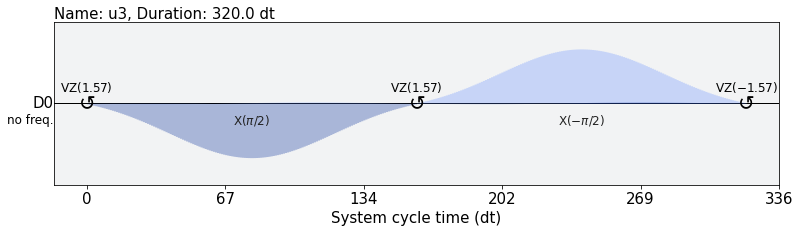

In [7]:
# See pulse schedule
# For instance rx(theta) = U3(theta,-pi/2,pi/2) 
# RX(pi/2) on qubit 0
rxpulse=inst_map.get("u3", P0=np.pi/2, P1=-np.pi/2, P2=np.pi/2, qubits=(QQ[0], ))

# Draw
rxpulse.draw()

In [8]:
# TWO PULSES

# Let's extract the details
print(rxpulse.instructions)

((0, ShiftPhase(-1.5707963267949, DriveChannel(0))), (0, ShiftPhase(-1.5707963267949, ControlChannel(1))), (0, Play(Drag(duration=160, amp=(0.09366468997026749+0.0011621092610225698j), sigma=40, beta=-1.0614992741586917, name='X90p_d0'), DriveChannel(0), name='X90p_d0')), (160, ShiftPhase(-1.5707963267949, DriveChannel(0))), (160, ShiftPhase(-1.5707963267949, ControlChannel(1))), (160, Play(Drag(duration=160, amp=(-0.09366468997026749-0.0011621092610225605j), sigma=40, beta=-1.0614992741586917, name='X90m_d0'), DriveChannel(0), name='X90m_d0')), (320, ShiftPhase(1.5707963267949, DriveChannel(0))), (320, ShiftPhase(1.5707963267949, ControlChannel(1))))


In [9]:
# Pulses are descrived by "Play(...)" and also the ShiftGates (which are the virtual RZ gates)
# Copy-pasting manually:
pulse_base_1 = Drag(duration=160,
                        amp=0.09607405443942843+0.002140194895714833j,
                        sigma=40,
                        beta=-1.0140042182448328,
                        name="RXcustom1")
    
pulse_base_2 = Drag(duration=160,
                        amp=-0.09607405443942843-0.002140194895714828j,
                        sigma=40,
                        beta=-1.0140042182448328,
                        name="RXcustom2")
# custom schedule
sched = Schedule(name = "RXcustom")
sched |= ShiftPhase(-1.5707963268, DriveChannel(QQ[0]))
sched |= Play(pulse_base_1, DriveChannel(QQ[0])) << sched.duration
sched |= ShiftPhase(-1.5707963268, DriveChannel(QQ[0])) << sched.duration
sched |= Play(pulse_base_2, DriveChannel(QQ[0])) << sched.duration
sched |= ShiftPhase(1.5707963268, DriveChannel(QQ[0])) << sched.duration
# add this gate to the set (only on qubit 0)
inst_map.add("RXcustom", qubits=(QQ[0], ), schedule=sched)

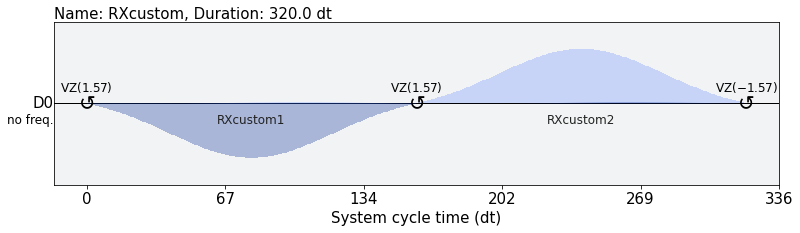

In [10]:
inst_map.get("RXcustom",qubits=(QQ[0])).draw()

In [11]:
# available gates
print(inst_map.instructions)

['cx', 'id', 'measure', 'rz', 'sx', 'u1', 'u2', 'u3', 'x', 'RXcustom']


In [12]:
# Haddamard gate is not a default but can be obtain from u2 gate
Hgate=inst_map.get("u2", P0=np.pi, P1=0, qubits=(QQ[0], ))

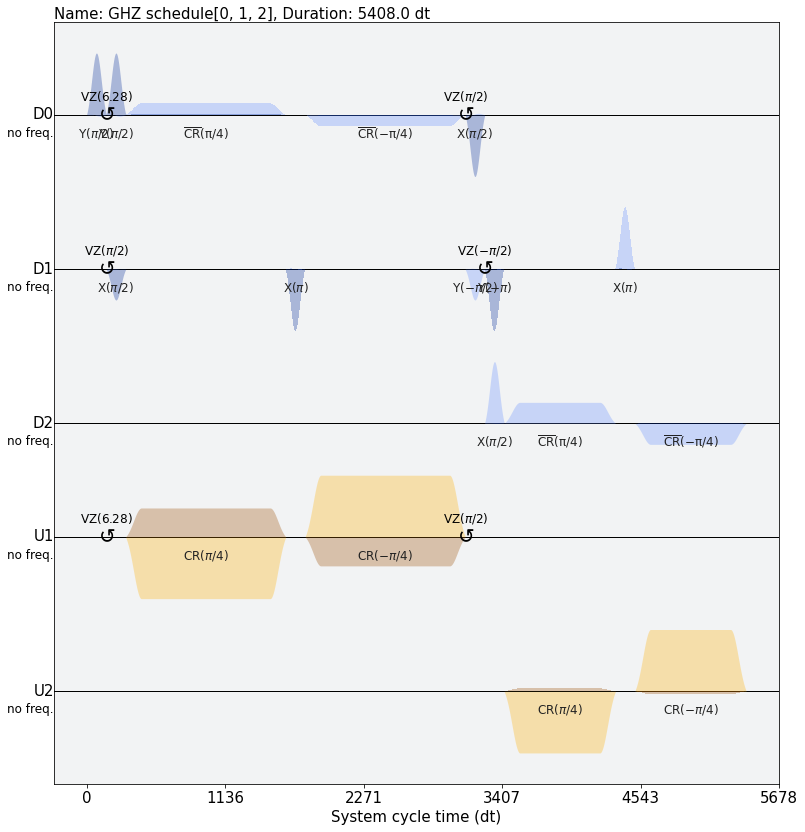

In [13]:
# Schedule 3-qubit GHZ state
# BEFORE APPLYING CNOTS, CHECK CHIP CONNECTIVITY (linear for Bogota)
qq=[0,1,2]
sched = pulse.Schedule(name=f"GHZ schedule{qq}")
sched |= Hgate
sched |= inst_map.get('cx', qubits=(qq[0], qq[1])) << sched.duration
sched |= inst_map.get('cx', qubits=(qq[1], qq[2])) << sched.duration
sched.draw()

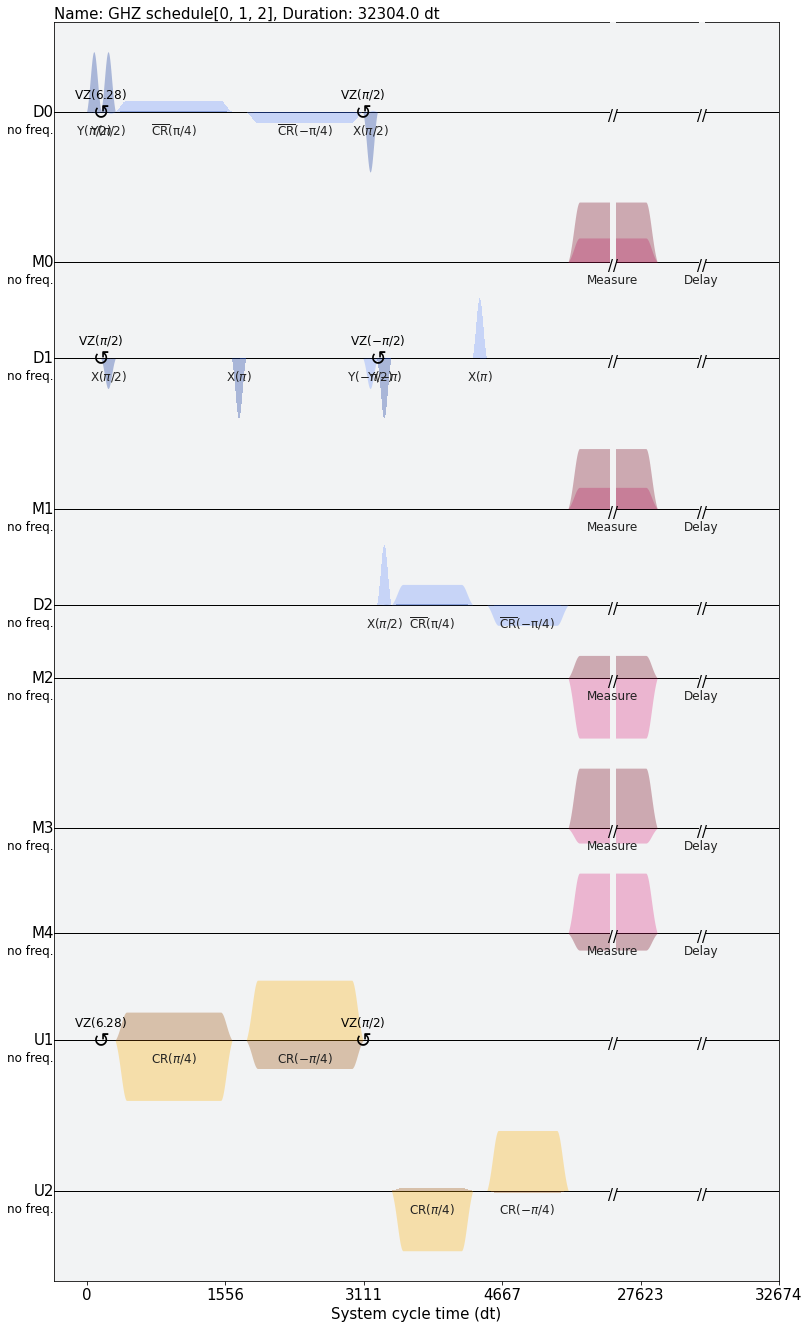

In [14]:
# add measurement
sched |= inst_map.get('measure', qubits=QQ) << sched.duration
sched.draw()

In [16]:
# RUN! 
GHZ_exp = assemble(sched, backend, shots=512)
GHZ_job = backend.run(GHZ_exp)
job_id_GHZ = GHZ_job.job_id()
print(f"job id: {job_id_GHZ}")

C:\Users\albac\AppData\Local\Continuum\anaconda3\envs\tqenv2\lib\site-packages\qiskit\compiler\assembler.py:309: RuntimeWarning: Dynamic rep rates are supported on this backend. 'rep_delay' will be used instead of 'rep_time'.
  warnings.warn("Dynamic rep rates are supported on this backend. 'rep_delay' will be "
<ipython-input-16-a3165b56dea6>:3: DeprecationWarning: Passing a Qobj to Backend.run is deprecated and will be removed in a future release. Please pass in circuits or pulse schedules instead.
  GHZ_job = backend.run(GHZ_exp)


job id: 623b6d9ca2f72d6ebddaaf4d


In [17]:
# retieve data
job_id = "623b6d9ca2f72d6ebddaaf4d" 
backend = provider.get_backend('ibmq_bogota')
ghz_job = backend.retrieve_job(job_id)

234
189


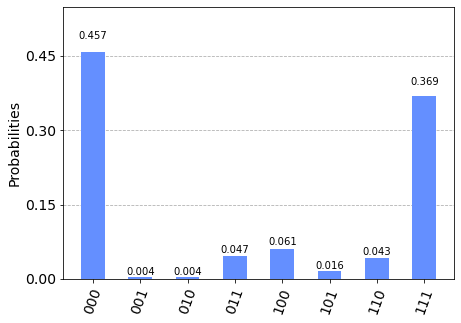

In [21]:
from qiskit.visualization import plot_histogram
all_counts = marginal_counts(ghz_job.result().get_counts(), [0,1,2], True)
exp_data_000 = all_counts.get('000')
exp_data_111 = all_counts.get('111')
print(exp_data_000)
print(exp_data_111)
plot_histogram(all_counts)